<a href="https://colab.research.google.com/github/SeanMuInCa/learn_python/blob/master/groupassignment2025retry5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install keras-tuner
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


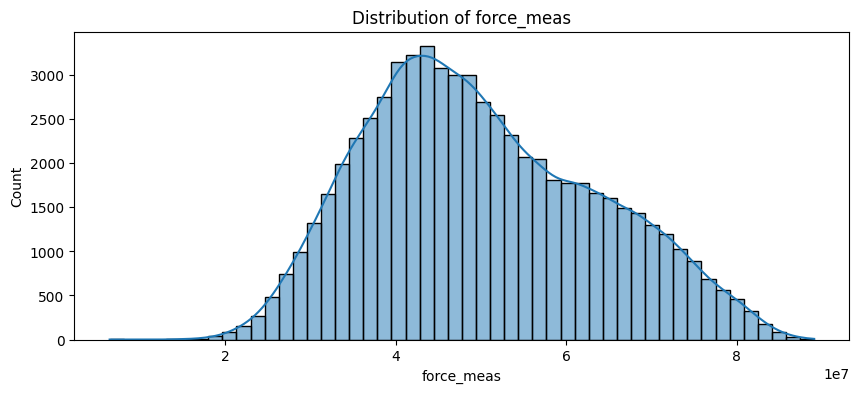

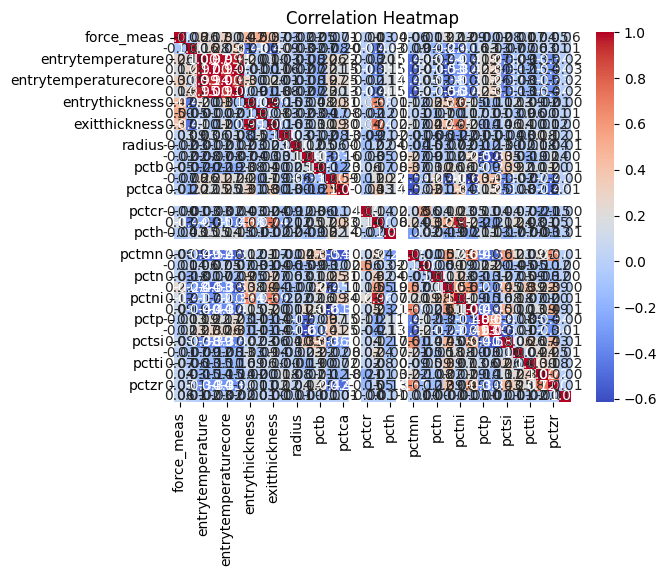

In [2]:
# ----------------------------
# Step 1: Load and Explore Data
# ----------------------------
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# EDA: Distribution and correlation
plt.figure(figsize=(10, 4))
sns.histplot(df['force_meas'], bins=50, kde=True)
plt.title('Distribution of force_meas')
plt.show()

sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [3]:
# ----------------------------
# Step 2: Preprocessing
# ----------------------------
def onehot(df_in):
    return pd.get_dummies(df_in, columns=['tappingsteelgrade'], drop_first=True)

# Split
X = df.drop(columns=['force_meas'])
y = df['force_meas'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test.drop(columns=['force_meas', 'force_pre'])
y_test = df_test['force_meas'].values
baseline_pre = df_test['force_pre'].values

X_train = onehot(X_train)
X_val   = onehot(X_val)
X_test  = onehot(X_test)

# Align columns
cols = X_train.columns.tolist()
with open('training_columns.pkl','wb') as f:
    pickle.dump(cols, f)

X_val = X_val.reindex(columns=cols, fill_value=0)
X_test = X_test.reindex(columns=cols, fill_value=0)

# Scale
scaler = StandardScaler().fit(X_train.values)
X_train_s = scaler.transform(X_train.values)
X_val_s = scaler.transform(X_val.values)
X_test_s = scaler.transform(X_test.values)

with open('scaler_dnn_log.pkl','wb') as f:
    pickle.dump(scaler, f)

# Log-transform target for DNN
y_train_log = np.log(y_train)
y_val_log = np.log(y_val)

In [4]:
# ----------------------------
# Step 3: Train RF and GB
# ----------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
rf.fit(X_train_s, y_train)
gb.fit(X_train_s, y_train)


GradientBoostingRegressor(random_state=42)

In [ ]:
# ----------------------------
# Step 4: Tune + Train DNN with log(y)
# ----------------------------
def build_model(hp):
    m = keras.Sequential([layers.Input(shape=(X_train_s.shape[1],))])
    for i in range(hp.Int('num_layers',4,6)):
        units = hp.Int(f'units_{i}',32,512,32)
        l2r = hp.Float(f'l2_{i}',1e-6,1e-3,sampling='LOG')
        m.add(layers.Dense(units, kernel_regularizer=regularizers.l2(l2r)))
        if hp.Choice(f'act_{i}', ['relu','leaky_relu'])=='leaky_relu':
            m.add(layers.LeakyReLU())
        else:
            m.add(layers.Activation('relu'))
        m.add(layers.Dropout(hp.Float(f'drop_{i}',0,0.5,0.1)))
        if hp.Boolean(f'bn_{i}'):
            m.add(layers.BatchNormalization())
    m.add(layers.Dense(1))
    lr = hp.Float('lr',1e-4,1e-2,sampling='LOG')
    m.compile(optimizer=keras.optimizers.Adam(lr), loss='mse', metrics=['mae'])
    return m

tuner = kt.RandomSearch(
    build_model, objective='val_mae',
    max_trials=30, executions_per_trial=1,
    directory='dnn_tuning', project_name='rolling_force_final'
)
tuner.search(X_train_s, y_train_log,
             validation_data=(X_val_s, y_val_log),
             epochs=50,
             callbacks=[keras.callbacks.EarlyStopping('val_mae',patience=5)])

best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)
model.fit(X_train_s, y_train_log,
          validation_data=(X_val_s, y_val_log),
          epochs=100, batch_size=256,
          callbacks=[
              keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=5, verbose=1),
              keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights=True)
          ])
model.save('optimized_dnn_model_final_log.h5')


Trial 5 Complete [00h 06m 03s]
val_mae: 0.11210526525974274

Best val_mae So Far: 0.07269218564033508
Total elapsed time: 00h 41m 03s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
5                 |4                 |num_layers
480               |320               |units_0
5.5147e-06        |2.6772e-06        |l2_0
relu              |relu              |act_0
0.1               |0.4               |drop_0
False             |True              |bn_0
64                |160               |units_1
7.1194e-05        |1.8567e-05        |l2_1
relu              |leaky_relu        |act_1
0.4               |0.1               |drop_1
False             |True              |bn_1
288               |416               |units_2
0.00018767        |3.3781e-06        |l2_2
leaky_relu        |relu              |act_2
0.4               |0.4               |drop_2
True              |False             |bn_2
384               |96                |units_3
1.6265e-06        |1.1723e-0

In [ ]:
# ----------------------------
# Step 5: Final Evaluation on Test
# ----------------------------
start = time.time()
y_pred_log = model.predict(X_test_s).flatten()
runtime = (time.time()-start)/len(X_test_s)

y_pred_dnn = np.exp(y_pred_log)

mae_dnn  = mean_absolute_error(y_test, y_pred_dnn)
rmse_dnn = np.sqrt(mean_squared_error(y_test, y_pred_dnn))
mse_dnn  = mean_squared_error(y_test, y_pred_dnn)

mae_rf  = mean_absolute_error(y_test, rf.predict(X_test_s))
mae_gb  = mean_absolute_error(y_test, gb.predict(X_test_s))
mae_base = mean_absolute_error(y_test, baseline_pre)

In [ ]:
# ----------------------------
# Step 6: Comparison Plot
# ----------------------------
models = ['Baseline', 'RF', 'GB', 'DNN']
maes = [mae_base, mae_rf, mae_gb, mae_dnn]
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=maes)
plt.ylabel('Test MAE')
plt.title('Model Comparison on Test Set')
plt.show()

print(f"DNN Test MAE: {mae_dnn:.4f}, RMSE: {rmse_dnn:.4f}, MSE: {mse_dnn:.4f}, time/sample: {runtime:.6f}s")
print(f"Baseline MAE: {mae_base:.4f}")